imports

In [106]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ( accuracy_score, f1_score, roc_auc_score , precision_score , recall_score , precision_recall_curve , 
                             average_precision_score,confusion_matrix , matthews_corrcoef)
from sklearn.metrics import RocCurveDisplay 
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score)
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

Note: you may need to restart the kernel to use updated packages.


read csv files

In [107]:
aisles=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\aisles.csv")
departments=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\departments.csv")
order_products_prior=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\order_products__prior.csv")
order_products_train=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\order_products__train.csv")
orders=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\orders.csv")
products=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\products.csv")

save memory

In [108]:
def reduce_memory(df):
  for column in df.columns:
    if df[column].dtype != object:
      if df[column].dtype == 'int64':
        df[column]=df[column].astype('int32')
      if df[column].dtype == 'float64':
        df[column]=df[column].astype('float32')
  return df
aisles=reduce_memory(aisles) 
departments=reduce_memory(departments) 
order_products_prior=reduce_memory(order_products_prior) 
order_products_train=reduce_memory(order_products_train) 
orders=reduce_memory(orders) 
products=reduce_memory(products)

join files 

In [109]:
all_products=products.merge(aisles,on='aisle_id',how='left')
all_products=all_products.merge(departments,on='department_id',how='left')
df=pd.merge(order_products_prior, all_products, on='product_id', how='left')
df_prior=pd.merge(df, orders, on='order_id', how='left')

In [110]:
df_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


EDA

1-missing value visualization

In [111]:
missing_values=df_prior.isnull().sum()
print(missing_values)

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64


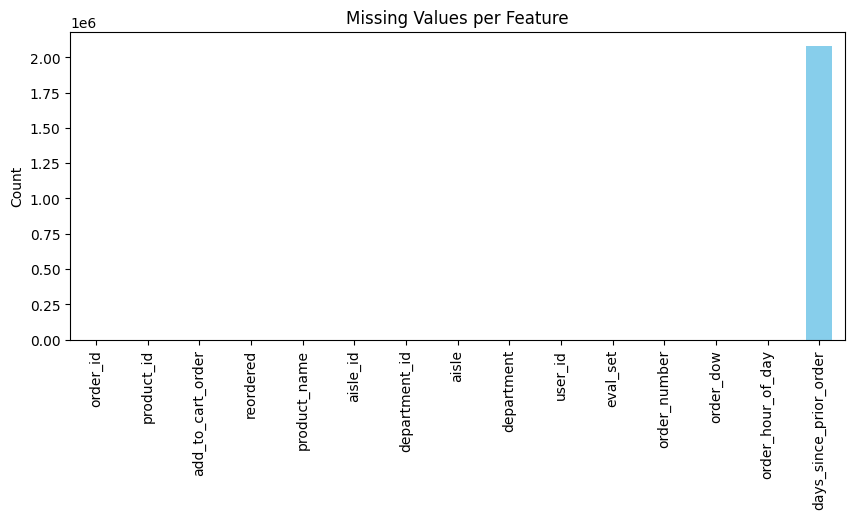

In [112]:
missing_values=df_prior.isnull().sum()
plt.figure(figsize=(10, 4))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Missing Values per Feature')
plt.ylabel('Count')
plt.show()

2-Distribution plots for numeric features and target(s) (histogram, density)

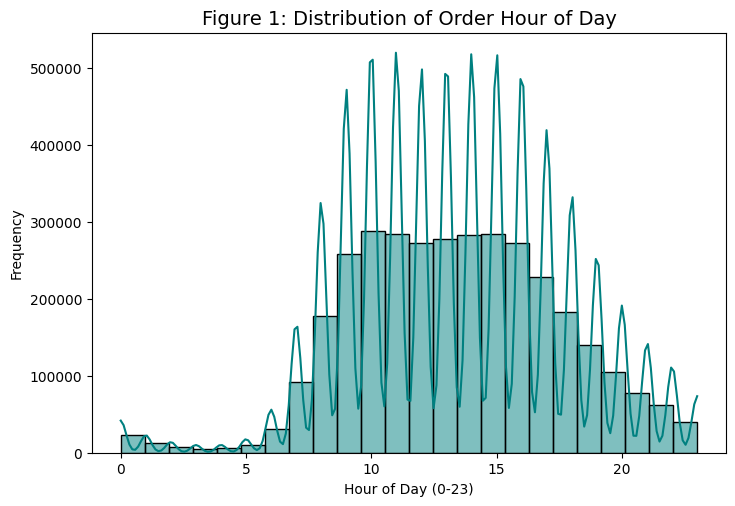

In [113]:
plt.figure(figsize=(18,12))
plt.subplot(2, 2, 1)
sns.histplot(orders['order_hour_of_day'], kde=True, color='teal', bins=24)
plt.title('Figure 1: Distribution of Order Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Frequency')
plt.show()

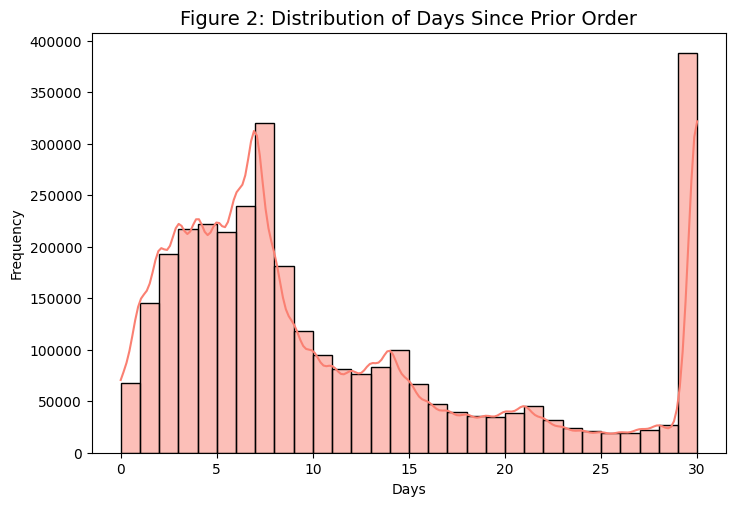

In [114]:
plt.figure(figsize=(18,12))
plt.subplot(2, 2, 2)
sns.histplot(orders['days_since_prior_order'], kde=True, color='salmon', bins=30)
plt.title('Figure 2: Distribution of Days Since Prior Order', fontsize=14)
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

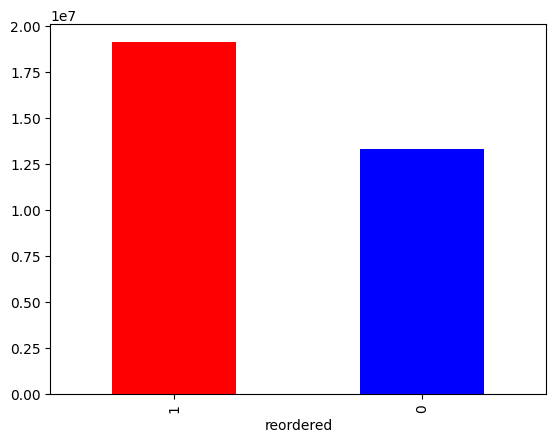

In [115]:
df['reordered'].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.show()

Categorical cardinality analysis

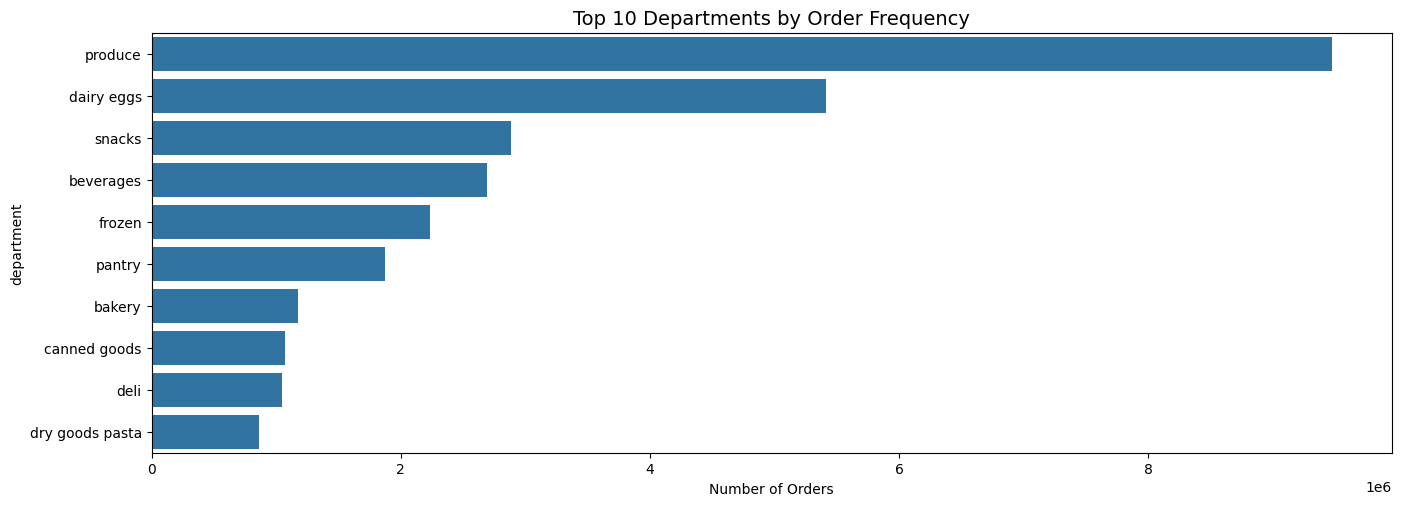

In [116]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
top_departments_counts = df_prior['department'].value_counts().head(10)
sns.barplot(x=top_departments_counts.values, y=top_departments_counts.index)
plt.title('Top 10 Departments by Order Frequency', fontsize=14)
plt.xlabel('Number of Orders')
plt.show()

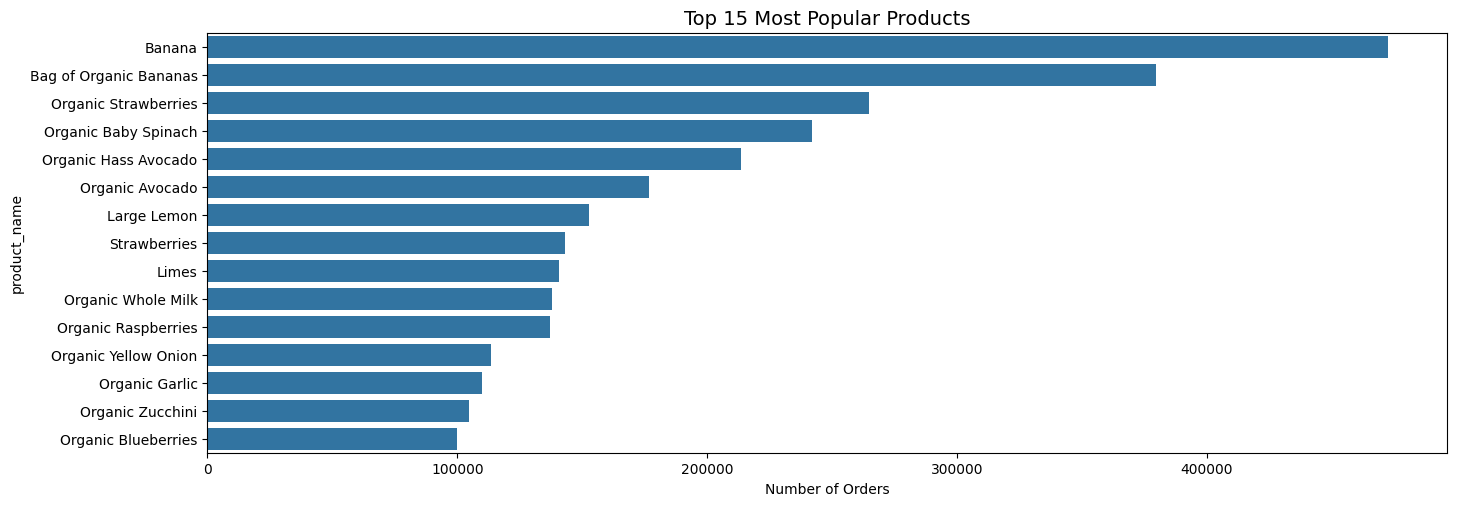

In [117]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 2)
top_products_counts = df_prior['product_name'].value_counts().head(15)
sns.barplot(x=top_products_counts.values, y=top_products_counts.index)
plt.title('Top 15 Most Popular Products', fontsize=14)
plt.xlabel('Number of Orders')
plt.show()

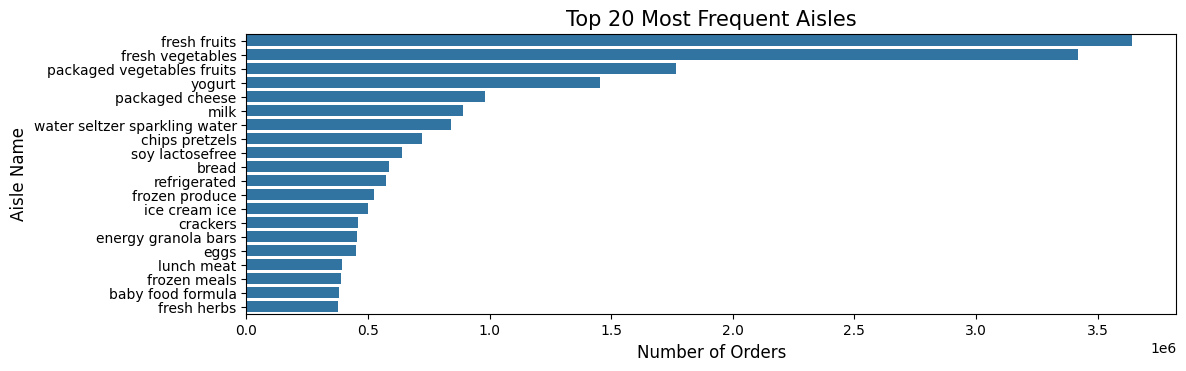

In [118]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
top_aisle_counts = df_prior['aisle'].value_counts().head(20)
sns.barplot(x=top_aisle_counts.values, y=top_aisle_counts.index)
plt.title('Top 20 Most Frequent Aisles', fontsize=15)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Aisle Name', fontsize=12)
plt.show()

Correlation matrix, heatmap and pairwise scatter plots for selected numeric features

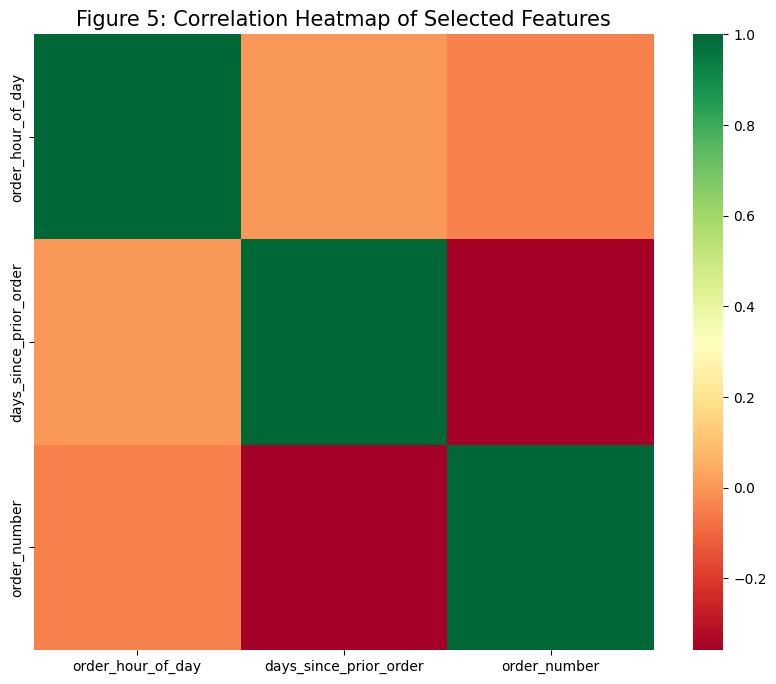

In [119]:
numeric_columns=['order_hour_of_day','days_since_prior_order','order_number']
corr_matrix=df_prior[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,cmap='RdYlGn')
plt.title('Figure 5: Correlation Heatmap of Selected Features', fontsize=15)
plt.show()


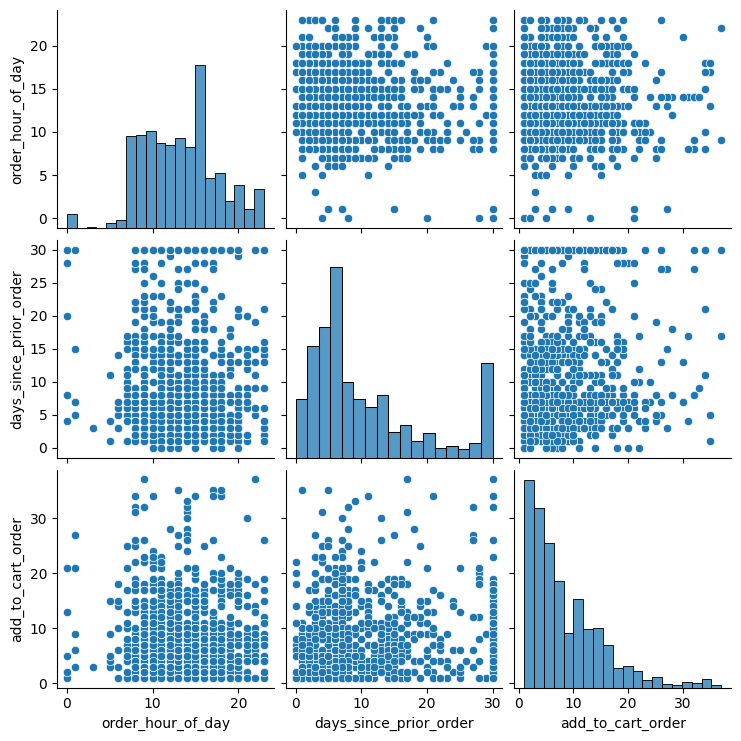

In [120]:
cols = ['order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order']
df_sample = df_prior[cols].sample(1000)
sns.pairplot(df_sample)
plt.show()

Cleaning & Imputation

In [121]:
df_prior['days_since_prior_order_sentinel'] = df_prior['days_since_prior_order'].fillna(-1)
median_value = df_prior['days_since_prior_order'].median()
df_prior['days_since_prior_order'] = df_prior['days_since_prior_order'].fillna(median_value)
print("for insurance:")
print(df_prior['days_since_prior_order'].isna().sum())
print((df_prior['days_since_prior_order_sentinel'] == -1).sum())
print()
print(median_value)
df_prior['days_since_prior_order'].describe()

for insurance:
0
2078068

8.0


count    3.243449e+07
mean     1.090520e+01
std      8.526975e+00
min      0.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

In [122]:
Q1 = df_prior['days_since_prior_order'].quantile(0.25)
Q3 = df_prior['days_since_prior_order'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = df_prior[(df_prior['days_since_prior_order'] < lower) | (df_prior['days_since_prior_order'] > upper)]
print("Nmber of outliers: ",len(outliers))

Nmber of outliers:  3499046


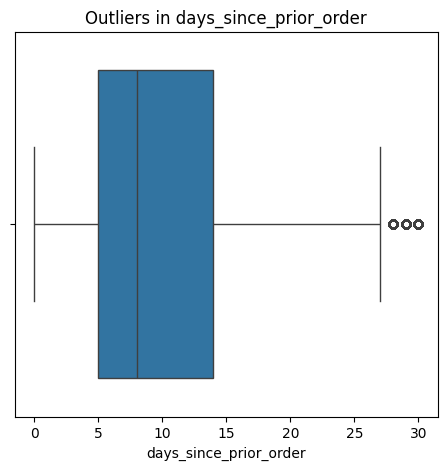

In [123]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x=df_prior['days_since_prior_order'])
plt.title("Outliers in days_since_prior_order")
plt.show()

In [124]:
df_prior['days_since_prior_order_winsorized'] = winsorize(df_prior['days_since_prior_order'], limits=[0.05, 0.05] )  # winsorization=0.05

In [125]:
upper_limit = df_prior['days_since_prior_order'].quantile(0.95)
(df_prior['days_since_prior_order_winsorized'] > upper_limit).sum()

np.int64(0)

Feature engineering

In [126]:
user_features = df_prior.groupby('user_id').agg(
    total_orders=('order_number', 'max'),
    reorder_ratio=('reordered', 'mean'),
    avg_basket_size=('product_id', 'count') ,
    mean_days_between_orders=('days_since_prior_order','mean'),
    last_order_recency=('days_since_prior_order','last')
).reset_index()
user_features['avg_basket_size'] = user_features['avg_basket_size'] / user_features['total_orders']

product_features=df_prior.groupby('product_id').agg(
    overall_reorder_rate=('reordered', 'mean'),
    average_position_in_cart=('add_to_cart_order','mean'),
    popularity=('order_id', 'count')
).reset_index()


User_Product_interaction=df_prior.groupby(['user_id', 'product_id']).agg(
    prior_purchase_count=('order_id', 'count'),
    days_since_last_purchase=('days_since_prior_order', 'last'),
    avg_reorder_prob=('reordered', 'mean')
).reset_index()

orders['is_weekend'] = orders['order_dow'].apply(lambda x: 1 if x in [0, 1] else 0)
temporal_features = orders[['order_id', 'order_hour_of_day', 'order_dow', 'is_weekend']]
#
last_3_orders = df_prior.sort_values(['user_id', 'order_number']).groupby('user_id').tail(3)
window_features = last_3_orders.groupby('user_id').agg(
    last_3_reorder_rate=('reordered', 'mean')
).reset_index()
#Log Transform (For large numbers) like total_orders
user_features['log_total_orders'] = np.log1p(user_features['total_orders'])
#interaction terms for correlate behavior
user_features['order_delay_ratio'] = user_features['last_order_recency'] / (user_features['mean_days_between_orders'] + 1)







Final Training Set

In [127]:
train_base = order_products_train.merge(orders[['order_id', 'user_id']], on='order_id', how='left')
train_base = train_base[['user_id', 'product_id', 'order_id', 'reordered']] # we removed add to cart order (Data Leakage)(Accuracy increases)


df_final = train_base.merge(user_features, on='user_id', how='left')
df_final = df_final.merge(product_features, on='product_id', how='left')
df_final = df_final.merge(User_Product_interaction, on=['user_id', 'product_id'], how='left')
df_final = df_final.merge(window_features, on='user_id', how='left')
df_final = df_final.merge(temporal_features, on='order_id', how='left')




In [128]:
df_final.head()

,user_id,product_id,order_id,reordered,total_orders,reorder_ratio,avg_basket_size,mean_days_between_orders,last_order_recency,log_total_orders,...,overall_reorder_rate,average_position_in_cart,popularity,prior_purchase_count,days_since_last_purchase,avg_reorder_prob,last_3_reorder_rate,order_hour_of_day,order_dow,is_weekend
0,112108,49302,1,1,3,0.428571,7.0,9.285714,7.0,1.386294,...,0.619632,6.392638,163.0,2.0,7.0,0.5,0.666667,10,4,0
1,112108,11109,1,1,3,0.428571,7.0,9.285714,7.0,1.386294,...,0.713775,7.385957,4472.0,2.0,7.0,0.5,0.666667,10,4,0
2,112108,10246,1,0,3,0.428571,7.0,9.285714,7.0,1.386294,...,0.524553,9.608327,23826.0,NaN,NaN,NaN,0.666667,10,4,0
3,112108,49683,1,0,3,0.428571,7.0,9.285714,7.0,1.386294,...,0.691702,7.662467,97315.0,NaN,NaN,NaN,0.666667,10,4,0
4,112108,43633,1,1,3,0.428571,7.0,9.285714,7.0,1.386294,...,0.477795,9.248086,653.0,2.0,8.0,0.5,0.666667,10,4,0


In [129]:
df_final.isnull().sum()

user_id                          0
product_id                       0
order_id                         0
reordered                        0
total_orders                     0
reorder_ratio                    0
avg_basket_size                  0
mean_days_between_orders         0
last_order_recency               0
log_total_orders                 0
order_delay_ratio                0
overall_reorder_rate             9
average_position_in_cart         9
popularity                       9
prior_purchase_count        555793
days_since_last_purchase    555793
avg_reorder_prob            555793
last_3_reorder_rate              0
order_hour_of_day                0
order_dow                        0
is_weekend                       0
dtype: int64

clean the nan values in df_final

In [130]:
df_final['overall_reorder_rate'].fillna(0, inplace=True)
df_final['average_position_in_cart'].fillna(df_final['average_position_in_cart'].mean(), inplace=True)
df_final['popularity'].fillna(0, inplace=True)
# we will drop the large numbers of nan values because if we keep them they will overfit
columns_to_drop=['prior_purchase_count','days_since_last_purchase','avg_reorder_prob']
df_final=df_final.drop(columns_to_drop,axis=1)

C:\Users\kareem khouri\AppData\Local\Temp\ipykernel_19284\970615039.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['overall_reorder_rate'].fillna(0, inplace=True)
C:\Users\kareem khouri\AppData\Local\Temp\ipykernel_19284\970615039.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

Outlier detection


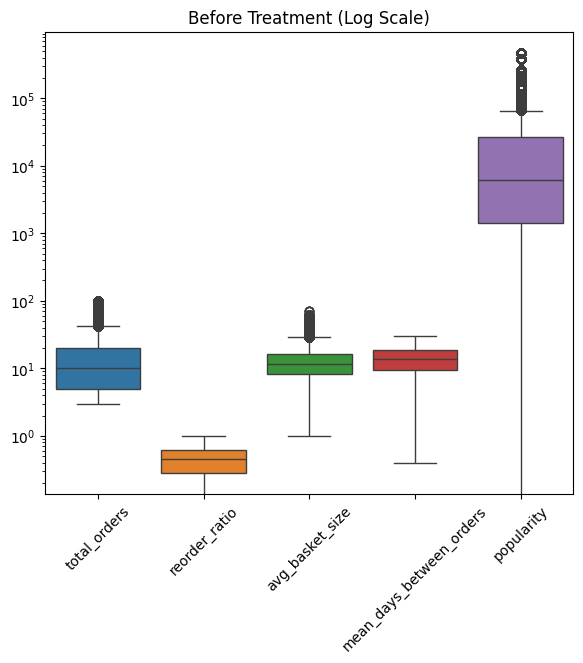

In [131]:


# List of numeric features from your dataset
numeric_cols = [
    'total_orders', 'reorder_ratio', 'avg_basket_size', 
    'mean_days_between_orders','popularity'
]

# Before Treatment
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_final[numeric_cols])
plt.yscale('log') # Use log scale to handle different feature magnitudes
plt.title("Before Treatment (Log Scale)")
plt.xticks(rotation=45)
plt.show()


In [132]:
#Treatment
for col in numeric_cols:
    if col in df_final.columns:
        df_final[col] = winsorize(df_final[col], limits=[0.01, 0.01])

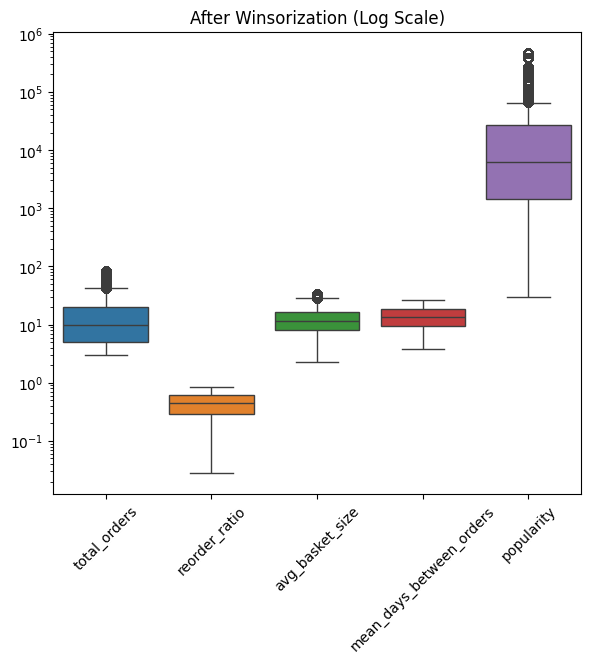

In [133]:
# After Treatment
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 2)
sns.boxplot(data=df_final[numeric_cols])
plt.yscale('log')
plt.title("After Winsorization (Log Scale)")
plt.xticks(rotation=45)
plt.show()

Time-Aware Splitting

In [134]:
#We will split the dataset into 80% past data for training and 20% future data for testing.
df_final = df_final.sort_values('order_id').reset_index(drop=True)
split_index = int(len(df_final) * 0.8)
train_df = df_final.iloc[:split_index].copy()
test_df  = df_final.iloc[split_index:].copy()

X_train = train_df.drop(['reordered',], axis=1)
y_train = train_df['reordered']
X_test = test_df.drop(['reordered',], axis=1)
y_test = test_df['reordered']

Encoding Categorical Variables

In [135]:
#One Hot Encoding
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
ohe_cols = ['order_dow', 'order_hour_of_day']
ohe.fit(X_train[ohe_cols])
X_train_ohe = ohe.transform(X_train[ohe_cols])
X_test_ohe = ohe.transform(X_test[ohe_cols])

ohe_feature_names = ohe.get_feature_names_out(ohe_cols)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_feature_names, index=X_train.index)

X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_feature_names, index=X_test.index)

X_train = X_train.drop(ohe_cols, axis=1)
X_test = X_test.drop(ohe_cols, axis=1)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)

In [136]:
#Frequency Encoding
user_freq = X_train['user_id'].value_counts(normalize=True)
product_freq = X_train['product_id'].value_counts(normalize=True)

X_train['user_id_freq'] = X_train['user_id'].map(user_freq)
X_train['product_id_freq'] = X_train['product_id'].map(product_freq)
X_test['user_id_freq'] = X_test['user_id'].map(user_freq)
X_test['product_id_freq'] = X_test['product_id'].map(product_freq)

X_test[['user_id_freq', 'product_id_freq']] = (X_test[['user_id_freq', 'product_id_freq']].fillna(0))

In [137]:
#Target Encoding using K fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train):
    train_users = X_train.iloc[train_idx]
    val_users = X_train.iloc[val_idx]

    user_means = y_train.iloc[train_idx].groupby(train_users['user_id']).mean()
    X_train.loc[val_users.index, 'target_user_id'] = val_users['user_id'].map(user_means)

X_train['target_user_id'].fillna(y_train.mean(), inplace=True)

user_means_full = y_train.groupby(X_train['user_id']).mean()
X_test['target_user_id'] = X_test['user_id'].map(user_means_full)
X_test['target_user_id'].fillna(y_train.mean(), inplace=True)




for train_idx, val_idx in kf.split(X_train):
    train_users = X_train.iloc[train_idx]
    val_users = X_train.iloc[val_idx]

    user_means = y_train.iloc[train_idx].groupby(train_users['product_id']).mean()
    X_train.loc[val_users.index, 'target_product_id'] = val_users['product_id'].map(user_means)

X_train['target_product_id'].fillna(y_train.mean(), inplace=True)

user_means_full = y_train.groupby(X_train['product_id']).mean()
X_test['target_product_id'] = X_test['product_id'].map(user_means_full)
X_test['target_product_id'].fillna(y_train.mean(), inplace=True)

X_train.drop(columns=['product_id','user_id'], inplace=True)
X_test.drop(columns=['product_id','user_id'], inplace=True)

C:\Users\kareem khouri\AppData\Local\Temp\ipykernel_19284\3264282718.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['target_user_id'].fillna(y_train.mean(), inplace=True)
C:\Users\kareem khouri\AppData\Local\Temp\ipykernel_19284\3264282718.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [138]:
#Feature scaling
numeric_col=['total_orders','log_total_orders','reorder_ratio','avg_basket_size','mean_days_between_orders','last_order_recency',
             'order_delay_ratio','overall_reorder_rate','average_position_in_cart','popularity','last_3_reorder_rate','user_id_freq', 
             'product_id_freq', 'target_user_id', 'target_product_id']

sc=StandardScaler()
#X_train_scaled and X_test_scaled for linear models , KNN and SVM
#We will use X_train and X_test for the others
X_train_scaled=X_train.copy()
X_test_scaled=X_test.copy()

X_train_scaled[numeric_col]=sc.fit_transform(X_train_scaled[numeric_col])
X_test_scaled[numeric_col]=sc.transform(X_test_scaled[numeric_col])

Dimensionality & Collinearity

In [139]:
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_col # Using your previously defined list
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled[numeric_col].values, i) 
                          for i in range(len(numeric_col))]

print(vif_data.sort_values(by="VIF", ascending=False))

                     feature         VIF
9                 popularity  108.550568
12           product_id_freq  108.044702
5         last_order_recency   12.378218
1           log_total_orders    8.856508
6          order_delay_ratio    8.564188
0               total_orders    6.623606
4   mean_days_between_orders    4.937936
2              reorder_ratio    3.583130
7       overall_reorder_rate    3.390970
14         target_product_id    2.886354
3            avg_basket_size    2.062630
11              user_id_freq    1.899511
8   average_position_in_cart    1.669436
13            target_user_id    1.609941
10       last_3_reorder_rate    1.303196


In [140]:
cols_to_drop = ['popularity','last_order_recency','total_orders']
X_train_scaled.drop(columns=cols_to_drop, inplace=True,errors='ignore')
X_test_scaled.drop(columns=cols_to_drop, inplace=True,errors='ignore')

# We'll ensure everything is below 10

new_numeric_cols = [c for c in numeric_col if c not in cols_to_drop]
vif_df = pd.DataFrame()
vif_df["feature"] = new_numeric_cols
vif_df["VIF"] = [variance_inflation_factor(X_train_scaled[new_numeric_cols].values, i) 
                 for i in range(len(new_numeric_cols))]

print(vif_df.sort_values(by="VIF", ascending=False))

                     feature       VIF
1              reorder_ratio  3.524240
5       overall_reorder_rate  3.389890
0           log_total_orders  3.040080
11         target_product_id  2.885611
2            avg_basket_size  2.061171
8               user_id_freq  1.898858
6   average_position_in_cart  1.663390
10            target_user_id  1.609770
3   mean_days_between_orders  1.373884
9            product_id_freq  1.304240
7        last_3_reorder_rate  1.303000
4          order_delay_ratio  1.004613


Imbalanced Data Handling

In [141]:
#Checking the imbalance
y_train.value_counts(normalize=True)

reordered
1    0.598556
0    0.401444
Name: proportion, dtype: float64

In [142]:
# No imbalance handling baseline model
lr_baseline = LogisticRegression(max_iter=1000, random_state=42)
lr_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = lr_baseline.predict(X_test_scaled)

print("Baseline, no imbalance handling")
print(classification_report(y_test, y_pred_baseline))

Baseline, no imbalance handling
              precision    recall  f1-score   support

           0       0.71      0.34      0.46    111116
           1       0.67      0.91      0.77    165808

    accuracy                           0.68    276924
   macro avg       0.69      0.62      0.62    276924
weighted avg       0.69      0.68      0.65    276924



In [143]:
lr_weighted = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_weighted.fit(X_train_scaled, y_train)
y_pred_weighted = lr_weighted.predict(X_test_scaled)

print("Class-weighted Logistic Regression")
print(classification_report(y_test, y_pred_weighted))

Class-weighted Logistic Regression
              precision    recall  f1-score   support

           0       0.64      0.56      0.60    111116
           1       0.73      0.79      0.76    165808

    accuracy                           0.70    276924
   macro avg       0.68      0.67      0.68    276924
weighted avg       0.69      0.70      0.69    276924



In [144]:
#Imbalanced data handling using Undersampling
print("Class distribution before undersampling:")
print(y_train.value_counts(normalize=True))

rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train_scaled, y_train)

print("Class distribution after undersampling:")
print(y_train_under.value_counts(normalize=True))

Class distribution before undersampling:
reordered
1    0.598556
0    0.401444
Name: proportion, dtype: float64
Class distribution after undersampling:
reordered
0    0.5
1    0.5
Name: proportion, dtype: float64


In [145]:
lr_under = LogisticRegression(max_iter=1000, random_state=42)
lr_under.fit(X_train_under, y_train_under)
y_pred_under = lr_under.predict(X_test_scaled)

print("Undersampling experiment") 
print(classification_report(y_test, y_pred_under))
#Balances classes by removing majority of the samples.

Undersampling experiment
              precision    recall  f1-score   support

           0       0.64      0.56      0.60    111116
           1       0.73      0.79      0.76    165808

    accuracy                           0.70    276924
   macro avg       0.68      0.67      0.68    276924
weighted avg       0.69      0.70      0.69    276924



Classification Task

c:\Users\kareem khouri\Desktop\project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Accuracy: 0.6966207334864439
Precision: 0.7287524121151103
Recall: 0.7857883817427386
F1_score: 0.7561964404384303
ROC_AUC_Score: 0.7512599940633009


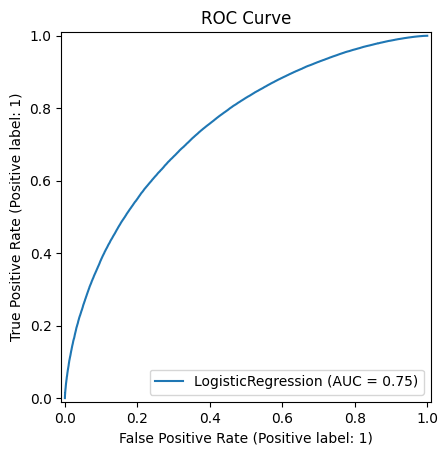

Average_Precision: 0.8107090868052866


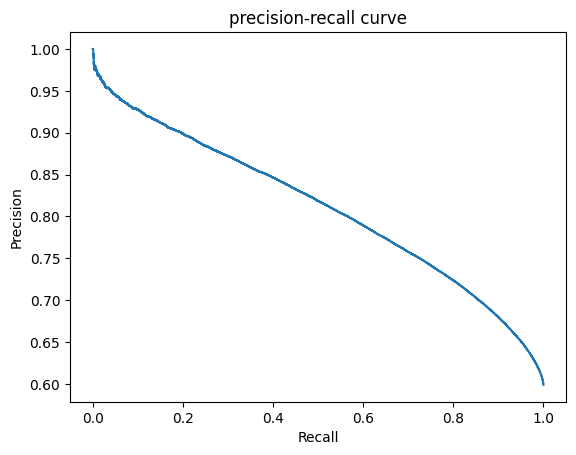

prob_true: [0.36191524 0.72875241]
prob_pred: [0. 1.]

MCC: 0.3579881469978723
confusion_matrix:


array([[0.56, 0.44],
       [0.21, 0.79]])

In [146]:
#Logistic Regression
lr=LogisticRegression(penalty='l2',max_iter=1000, random_state=42,class_weight='balanced')
lr.fit(X_train_scaled,y_train)
y_pred=lr.predict(X_test_scaled)
#Accuracy , Precision and F1 score
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Precision:",precision_score(y_test,y_pred))
print("Recall:",recall_score(y_test,y_pred))
print("F1_score:",f1_score(y_test,y_pred))
#ROC curve and AUC
y_probs = lr.predict_proba(X_test_scaled)[:, 1]
score = roc_auc_score(y_test, y_probs)
print(f"ROC_AUC_Score:",score)
#plot and calculate the curve
RocCurveDisplay.from_estimator(lr, X_test_scaled, y_test)
plt.title("ROC Curve")
plt.show()
#Precision-Recall curve and Average Precision
precision_values , recall_values,_= precision_recall_curve(y_test,y_probs)
ap=average_precision_score(y_test,y_probs)
print("Average_Precision:",ap)
#plot 
plt.plot(recall_values,precision_values,label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("precision-recall curve")
plt.show()
#calibration curve
prob_true , prob_pred = calibration_curve(y_test,y_pred,n_bins=3)
print("prob_true:",prob_true)
print("prob_pred:",prob_pred)
print()
#MCC
mcc=matthews_corrcoef(y_test,y_pred)
print("MCC:",mcc)
#confusion matrix
cm=confusion_matrix(y_test,y_pred)
print("confusion_matrix:")
np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)

Accuracy: 0.673224422585258
Precision: 0.6819104021950206
Recall: 0.8513762906494259
F1_score: 0.7572782722049665
ROC_AUC_Score: 0.7167724446218402


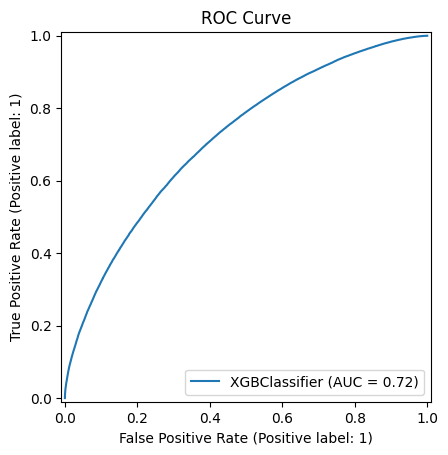

Average_Precision: 0.7827671130160193


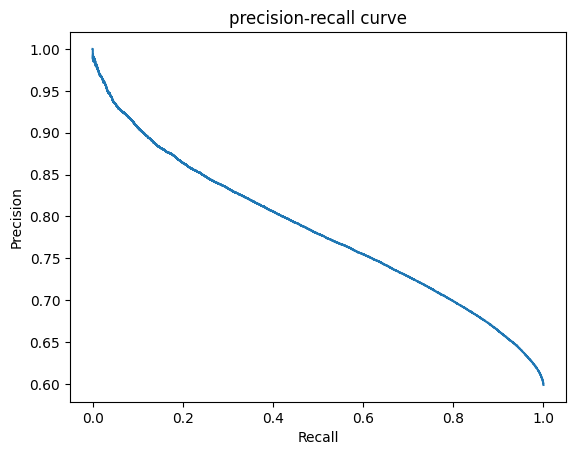

prob_true: [0.35249607 0.6819104 ]
prob_pred: [0. 1.]

MCC: 0.291958393304571
confusion_matrix:


array([[0.41, 0.59],
       [0.15, 0.85]])

In [147]:
#XGBoost
from xgboost import XGBClassifier

ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb=XGBClassifier(
    n_estimators=300,
    max_depth=6,     
    subsample=0.8,
    colsample_bytree=0.8,     
    scale_pos_weight=ratio,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train,y_train)
y_pred_xgb=xgb.predict(X_test)
#Accuracy , Precision and F1 score
print("Accuracy:",accuracy_score(y_test,y_pred_xgb))
print("Precision:",precision_score(y_test,y_pred_xgb))
print("Recall:",recall_score(y_test,y_pred_xgb))
print("F1_score:",f1_score(y_test,y_pred_xgb))
#ROC curve and AUC
y_probs_xgb = xgb.predict_proba(X_test)[:, 1]
score_xgb = roc_auc_score(y_test, y_probs_xgb)
print(f"ROC_AUC_Score:",score_xgb)
#plot and calculate the curve
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title("ROC Curve")
plt.show()
#Precision-Recall curve and Average Precision
precision_values , recall_values,_= precision_recall_curve(y_test,y_probs_xgb)
ap_xgb=average_precision_score(y_test,y_probs_xgb)
print("Average_Precision:",ap_xgb)
#plot 
plt.plot(recall_values,precision_values,label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("precision-recall curve")
plt.show()
#calibration curve
prob_true , prob_pred = calibration_curve(y_test,y_pred_xgb,n_bins=3)
print("prob_true:",prob_true)
print("prob_pred:",prob_pred)
print()
#MCC
mcc=matthews_corrcoef(y_test,y_pred_xgb)
print("MCC:",mcc)
#confusion matrix
cm=confusion_matrix(y_test,y_pred_xgb)
print("confusion_matrix:")
np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)

Accuracy: 0.6832668891103696
Precision: 0.7304766120702376
Recall: 0.7464115121103927
F1_score: 0.7383580972040342
ROC_AUC_Score: 0.7391427317184052


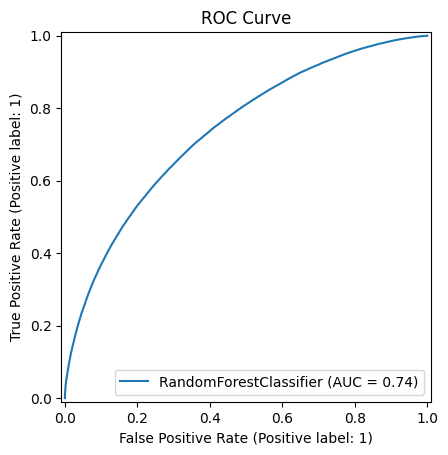

Average_Precision: 0.8032278508356401


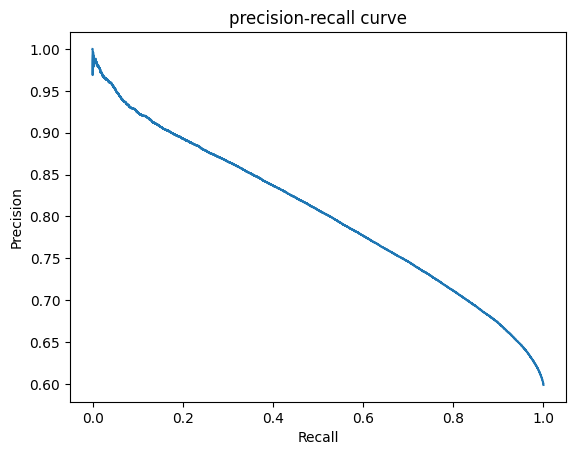

prob_true: [0.39113852 0.73047661]
prob_pred: [0. 1.]

MCC: 0.3373902516516581
confusion_matrix:


array([[0.59, 0.41],
       [0.25, 0.75]])

In [148]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(
    n_estimators=500,          
    max_depth=6,            
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',   
    random_state=42,
    n_jobs=-1
)

rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
#Accuracy , Precision and F1 score
print("Accuracy:",accuracy_score(y_test,y_pred_rfc))
print("Precision:",precision_score(y_test,y_pred_rfc))
print("Recall:",recall_score(y_test,y_pred_rfc))
print("F1_score:",f1_score(y_test,y_pred_rfc))
#ROC curve and AUC
y_probs_rfc = rfc.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, y_probs_rfc)
print(f"ROC_AUC_Score:",score)
#plot and calculate the curve
RocCurveDisplay.from_estimator(rfc, X_test, y_test)
plt.title("ROC Curve")
plt.show()
#Precision-Recall curve and Average Precision
precision_values , recall_values,_= precision_recall_curve(y_test,y_probs_rfc)
ap=average_precision_score(y_test,y_probs_rfc)
print("Average_Precision:",ap)
#plot 
plt.plot(recall_values,precision_values,label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("precision-recall curve")
plt.show()
#calibration curve
prob_true , prob_pred = calibration_curve(y_test,y_pred_rfc,n_bins=3)
print("prob_true:",prob_true)
print("prob_pred:",prob_pred)
print()
#MCC
mcc=matthews_corrcoef(y_test,y_pred_rfc)
print("MCC:",mcc)
#confusion matrix
cm=confusion_matrix(y_test,y_pred_rfc)
print("confusion_matrix:")
np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)


Regression Task

In [149]:
#Creating a new target feature 'reorder_count'
reorder_count_df = (df_final.groupby('order_id')['reordered'].sum().reset_index().rename(columns={'reordered': 'reorder_count'}))
df_reg = df_final.merge(reorder_count_df, on='order_id', how='left')

X_reg = df_reg.drop(columns=['reordered', 'reorder_count'])
y_reg = df_reg['reorder_count']

df_reg = df_reg.sort_values('order_id').reset_index(drop=True)

split_idx = int(len(df_reg) * 0.8)

X_train_reg = X_reg.iloc[:split_idx]
X_test_reg  = X_reg.iloc[split_idx:]
y_train_reg = y_reg.iloc[:split_idx]
y_test_reg  = y_reg.iloc[split_idx:]

MAE: 3.7483530388472244
MSE: 26.563312012237898
RMSE: 5.153960808178298
R2: 0.5759952366453547
Breusch-Pagan p-value: 0.0


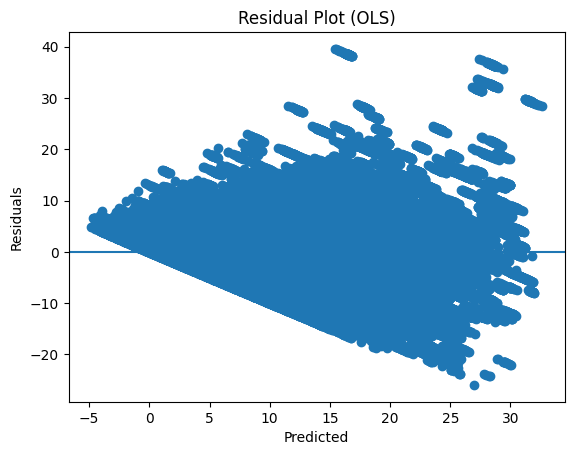

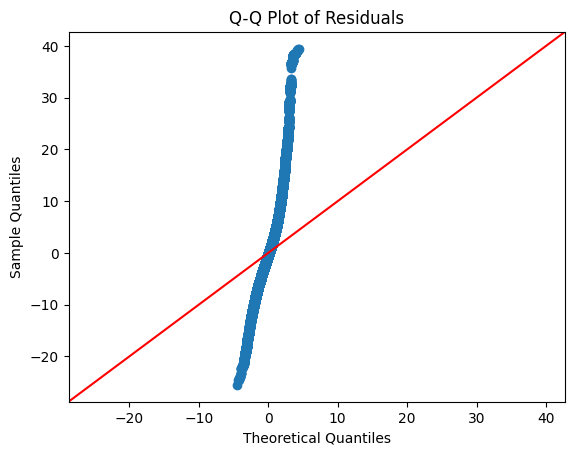

In [150]:
#Linear Regression
lin_r = LinearRegression()
lin_r.fit(X_train_reg, y_train_reg)
lin_y_pred = lin_r.predict(X_test_reg)
#Linear Regression with L1/L2 Regularization
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_reg, y_train_reg)
y_pred_ridge = ridge.predict(X_test_reg)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_reg, y_train_reg)
y_pred_lasso = lasso.predict(X_test_reg)

e_net = ElasticNet(alpha=0.01, l1_ratio=0.5)
e_net.fit(X_train_reg, y_train_reg)
y_pred_enet = e_net.predict(X_test_reg)

#Evaluation Metrics MAE, MSE, RMSE, R2
MAE = mean_absolute_error(y_test_reg, lin_y_pred)
MSE = mean_squared_error(y_test_reg, lin_y_pred)
RMSE = root_mean_squared_error(y_test_reg, lin_y_pred)
R2 = r2_score(y_test_reg, lin_y_pred)
print("MAE:", MAE)
print("MSE:", MSE)
print("RMSE:", RMSE)
print("R2:", R2)

#Breusch-Pagan test for Heteroscedasticity
X_sm = sm.add_constant(X_test_reg)
model_sm = sm.OLS(y_test_reg, X_sm).fit()
bp_test = het_breuschpagan(model_sm.resid, model_sm.model.exog)
bp_pvalue = bp_test[1]
print("Breusch-Pagan p-value:", bp_pvalue)
#It implies Heteroscedasticity if p-value < 0.05

#Residual Plot
residuals = y_test_reg - lin_y_pred
plt.scatter(lin_y_pred, residuals)
plt.axhline(0)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot (OLS)")
plt.show()
#Q-Q Plot
sm.qqplot(model_sm.resid, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()
